###### Batch Document Extraction with InternVL3.5-8B (V2 - H200 + bfloat16)

**H200 REFERENCE VERSION**: This notebook uses bfloat16 precision to establish baseline performance on modern GPU architecture.

**V2 Features:**
- **Sophisticated bank statement extraction** using multi-turn UnifiedBankExtractor
- Turn 0: Header detection (identifies actual column names)
- Turn 1: Adaptive extraction with structure-dynamic prompts
- Automatic strategy selection: BALANCE_DESCRIPTION, AMOUNT_DESCRIPTION, etc.

**Model**: InternVL3.5-8B (8.5B parameters: 0.3B vision + 8.2B language)

**Comparison Purpose**:
- **H200 + bfloat16**: Native hardware support, optimal performance (this notebook)
- **V100 + float32**: No bfloat16 support, requires full precision (ivl3_8b_batch.ipynb)

**Requirements**: 
- `transformers>=4.52.1` (critical for InternVL3.5 support)
- PyTorch with CUDA support
- H200/H100/A100 GPU (with native bfloat16 support)

**Key Features**:
- Cascade Reinforcement Learning (Cascade RL) for enhanced reasoning
- Visual Resolution Router (ViR) for dynamic resolution adjustment
- Flash Attention 2 enabled (H200 optimized)
- Improved performance over InternVL3 series

**Bank Statement Processing Toggle:**
- `USE_SOPHISTICATED_BANK_EXTRACTION`: True (default) uses multi-turn extraction
- `ENABLE_BALANCE_CORRECTION`: Optional mathematical balance validation

## 1. Imports

In [1]:
#Cell 1
# Project root detection - allows running from subdirectories
import os
import sys
from pathlib import Path

os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'

def find_project_root(marker_files=('common/__init__.py', 'CLAUDE.md', 'prompts')):
    """Find project root by looking for marker files, searching up from cwd."""
    current = Path().absolute()
    for parent in [current] + list(current.parents):
        for marker in marker_files:
            if (parent / marker).exists():
                return parent
    return current  # Fallback to cwd if no marker found

# Detect project root (works from any subdirectory)
PROJECT_ROOT = find_project_root()
print(f"📂 Current directory: {Path().absolute()}")
print(f"🏠 Project root: {PROJECT_ROOT}")

# Ensure the project root is in the Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print(f"✅ Added {PROJECT_ROOT} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod_2026/LMM_POC/notebooks_v2
🏠 Project root: /home/jovyan/nfs_share/tod_2026/LMM_POC
✅ Added /home/jovyan/nfs_share/tod_2026/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod_2026/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# V2: Sophisticated bank statement processing
from common.bank_statement_adapter import BankStatementAdapter

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Batch processing modules imported successfully")
print("✅ V2: BankStatementAdapter imported for sophisticated bank extraction")
print(f"📂 Working directory: {notebook_dir}")
print("🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES'], 'transaction_list': ['TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE', 'TRAVEL_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Batch processing modules imported successfully
✅ V2: BankStatementAdapter imported for sophistic

## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [4]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod_2026',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - InternVL3.5-8B
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    # Alternative paths:
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3_5-8B',
    # 'MODEL_PATH': 'OpenGVLab/InternVL3_5-8B',  # Auto-download from HuggingFace

    # Batch settings - Using base path for consistency
    # 'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/synthetic',
    # 'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv',
    'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/travel',
    'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/travel/ground_truth_travel.csv',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: False (evaluation mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # ============================================================================
    # H200 BFLOAT16 CONFIGURATION - OPTIMAL PERFORMANCE BASELINE
    # ============================================================================
    # This configuration uses H200's native bfloat16 support for optimal performance.
    # Compare against V100 float32 to understand hardware limitations impact.
    #
    # H200 advantages:
    # - Native bfloat16 hardware support (compute capability 9.0)
    # - Flash Attention 2 support for faster inference
    # - Higher memory bandwidth and capacity
    #
    # Configuration:
    # - bfloat16: Native hardware support, no conversion needed
    # - Flash Attention: Enabled for faster processing
    # - No quantization: Full precision for accuracy baseline
    # ============================================================================
    'USE_QUANTIZATION': False,  # Full precision for H200
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,
    'TORCH_DTYPE': 'bfloat16',  # Native H200 support
    'LOW_CPU_MEM_USAGE': False,  # Must be False - InternVL3.5 vision encoder incompatible with meta device init
    # Flash Attention: ENABLED for H200/H100/A100
    'USE_FLASH_ATTN': True,  # H200 optimized - faster inference

    # torch.compile: JIT compilation for optimized inference (PyTorch 2.x)
    # First inference is slower (compilation), subsequent runs are faster.
    # Use 'default' mode for variable input sizes (different tile counts per image).
    # Set to False to disable if torch.compile causes issues with custom model code.
    'USE_TORCH_COMPILE': True,
    
    # H200 TILE CONFIGURATION
    'MAX_TILES': 11,  # H200 optimized - InternVL3.5 training max for dense OCR
    
    # ============================================================================
    # V2: SOPHISTICATED BANK STATEMENT EXTRACTION
    # ============================================================================
    # Use multi-turn UnifiedBankExtractor for bank statements instead of
    # single-turn extraction. This provides:
    # - Turn 0: Header detection (identifies actual column names)
    # - Turn 1: Adaptive extraction with structure-dynamic prompts
    # - Automatic strategy selection based on detected columns
    # - Higher accuracy for bank statements
    #
    # Set to False to use original single-turn extraction behavior
    # ============================================================================
    'USE_SOPHISTICATED_BANK_EXTRACTION': True,
    
    # Optional: Enable balance-based mathematical correction
    # Uses balance column deltas to validate debit/credit values
    'ENABLE_BALANCE_CORRECTION': True,
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Uses PROJECT_ROOT for subdirectory compatibility
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# NOTE: When USE_SOPHISTICATED_BANK_EXTRACTION is True, bank statements bypass
# this configuration and use UnifiedBankExtractor with config/bank_prompts.yaml
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': str(PROJECT_ROOT / 'prompts/document_type_detection.yaml'),
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'RECEIPT': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        # BANK_STATEMENT: Only used if USE_SOPHISTICATED_BANK_EXTRACTION=False or as fallback
        'BANK_STATEMENT': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml'),
        'TRAVEL_EXPENSE': str(PROJECT_ROOT / 'prompts/internvl3_prompts.yaml')
    },
}

# Universal field list (hardcoded for consistency across notebooks)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
# These fields are only for mathematical validation, not extraction/evaluation
UNIVERSAL_FIELDS = [
    'DOCUMENT_TYPE',
    'BUSINESS_ABN',
    'SUPPLIER_NAME',
    'BUSINESS_ADDRESS',
    'PAYER_NAME',
    'PAYER_ADDRESS',
    'INVOICE_DATE',
    'STATEMENT_DATE_RANGE',
    'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES',
    'LINE_ITEM_PRICES',
    'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED',
    'GST_AMOUNT',
    'TOTAL_AMOUNT',
    'TRANSACTION_DATES',
    'TRANSACTION_AMOUNTS_PAID',
]

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print("🤖 Model: InternVL3.5-8B")
print(f"📁 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"🏠 Project root: {PROJECT_ROOT}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)} (validation-only fields excluded)")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print("⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)")
print(f"⚡ Flash Attention: {'ENABLED (H200 optimized)' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED'}")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']} (InternVL3.5 training max for dense OCR)")
print("🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution")
print(f"🏦 V2 Bank Extraction: {'Enabled (multi-turn)' if CONFIG['USE_SOPHISTICATED_BANK_EXTRACTION'] else 'Disabled (single-turn)'}")
print(f"📐 Balance Correction: {'Enabled' if CONFIG['ENABLE_BALANCE_CORRECTION'] else 'Disabled'}")
print(f"🔥 torch.compile: {'ENABLED (JIT optimization)' if CONFIG['USE_TORCH_COMPILE'] else 'DISABLED'}")
print("📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32")

✅ Configuration set up successfully
📂 Evaluation data: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/travel
📊 Ground truth: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/travel/ground_truth_travel.csv
🤖 Model: InternVL3.5-8B
📁 Model path: /home/jovyan/nfs_share/models/InternVL3_5-8B
📁 Output base: /home/jovyan/nfs_share/tod_2026/LMM_POC/output
🏠 Project root: /home/jovyan/nfs_share/tod_2026/LMM_POC
📋 Universal fields: 17 (validation-only fields excluded)
🎯 Mode: Evaluation mode
⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)
⚡ Flash Attention: ENABLED (H200 optimized)
🔲 Max Tiles: 11 (InternVL3.5 training max for dense OCR)
🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution
🏦 V2 Bank Extraction: Enabled (multi-turn)
📐 Balance Correction: Enabled
🔥 torch.compile: ENABLED (JIT optimization)
📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32


# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading

**InternVL3.5-8B**: Loading the latest InternVL3.5 model with Cascade RL and Visual Resolution Router.

**Requirements**: Ensure `transformers>=4.52.1` is installed for InternVL3.5 compatibility.

In [6]:
#Cell 6
# Load InternVL3.5-8B model
# Model page: https://huggingface.co/OpenGVLab/InternVL3_5-8B
# Using official loading pattern from HuggingFace model card

rprint("[bold green]Loading InternVL3.5-8B model...[/bold green]")
rprint("[cyan]🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)[/cyan]")
rprint("[cyan]📖 Features: Cascade RL, Visual Resolution Router (ViR)[/cyan]")

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    world_size = torch.cuda.device_count()
    rprint(f"[cyan]🖥️  Detected {world_size} GPU(s)[/cyan]")
    rprint("[cyan]📥 Loading model (official HuggingFace pattern)...[/cyan]")
    
    # Official loading pattern from https://huggingface.co/OpenGVLab/InternVL3_5-8B
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        trust_remote_code=True,
    ).eval().cuda()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # ============================================================================
    # torch.compile: JIT OPTIMIZATION (PyTorch 2.x)
    # ============================================================================
    # Compiles the model's forward pass for optimized CUDA kernel execution.
    # - First inference is slower (JIT compilation overhead)
    # - Subsequent inferences are faster (optimized kernels cached)
    # - mode="default": Safe for variable input sizes (different tile counts)
    # - Graceful fallback: If compile fails with custom code, model still works
    # ============================================================================
    torch_compile_active = False
    if CONFIG.get('USE_TORCH_COMPILE', False):
        rprint("[cyan]🔥 Applying torch.compile (JIT optimization)...[/cyan]")
        try:
            model = torch.compile(model, mode="default")
            torch_compile_active = True
            rprint("[green]✅ torch.compile applied (mode=default)[/green]")
            rprint("[dim]   First inference will be slower (JIT compilation), subsequent runs faster[/dim]")
        except Exception as e:
            rprint(f"[yellow]⚠️ torch.compile failed: {e}[/yellow]")
            rprint("[yellow]   Continuing without JIT optimization (model works normally)[/yellow]")
    
    # ============================================================================
    # GPU MEMORY DISPLAY
    # ============================================================================
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        
        if device_count > 1:
            rprint(f"[blue]🔄 GPU Memory Status ({device_count} GPUs available, model on GPU 0):[/blue]")
            
            total_allocated = 0
            total_capacity = 0
            
            for gpu_id in range(device_count):
                gpu_allocated = torch.cuda.memory_allocated(gpu_id) / 1e9
                gpu_capacity = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9
                gpu_name = torch.cuda.get_device_name(gpu_id)
                
                total_allocated += gpu_allocated
                total_capacity += gpu_capacity
                
                usage_pct = (gpu_allocated / gpu_capacity) * 100 if gpu_capacity > 0 else 0
                rprint(f"   GPU {gpu_id} ({gpu_name}): {gpu_allocated:.1f}GB/{gpu_capacity:.0f}GB ({usage_pct:.1f}%)")
            
            rprint(f"[blue]📊 Total: {total_allocated:.1f}GB allocated, {total_capacity:.0f}GB capacity[/blue]")
        else:
            allocated = torch.cuda.memory_allocated() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            gpu_name = torch.cuda.get_device_name(0)
            usage_pct = (allocated / total) * 100 if total > 0 else 0
            
            rprint(f"[blue]📊 GPU {gpu_name}: {allocated:.1f}GB/{total:.0f}GB ({usage_pct:.1f}%)[/blue]")
    
    # ============================================================================
    # CONFIGURATION TABLE
    # ============================================================================
    from rich.table import Table
    
    config_table = Table(title="🔧 InternVL3.5-8B Model Configuration")
    config_table.add_column("Setting", style="cyan")
    config_table.add_column("Value", style="yellow")
    config_table.add_column("Status", style="green")
    
    model_name = Path(CONFIG['MODEL_PATH']).name
    config_table.add_row("Model Path", model_name, "✅ Valid")
    config_table.add_row("Model Type", "InternVL3.5-8B", "✅ Cascade RL + ViR")
    config_table.add_row("Device Placement", str(next(model.parameters()).device), "✅ Loaded")
    
    quant_method = "16-bit" if not CONFIG['USE_QUANTIZATION'] else "8-bit"
    config_table.add_row("Quantization Method", quant_method, "✅ Configured")
    config_table.add_row("Data Type", "bfloat16", "✅ Recommended")
    config_table.add_row("Max New Tokens", str(CONFIG['MAX_NEW_TOKENS']), "✅ Generation Ready")
    config_table.add_row("Max Tiles", str(CONFIG['MAX_TILES']), "✅ H200 Optimized")
    
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        if device_count > 1:
            gpu_info = f"{device_count}x {torch.cuda.get_device_name(0)} ({total_capacity:.0f}GB total)"
            gpu_status = "✅ Model on GPU 0"
        else:
            gpu_info = f"{torch.cuda.get_device_name(0)} ({total:.0f}GB)"
            gpu_status = "✅ Single GPU"
    else:
        gpu_info = "CPU"
        gpu_status = "💻 CPU Mode"
    config_table.add_row("GPU Configuration", gpu_info, gpu_status)
    
    param_count = sum(p.numel() for p in model.parameters())
    config_table.add_row("Model Parameters", f"{param_count:,}", "✅ Loaded")
    
    flash_attn_status = "✅ Enabled" if CONFIG['USE_FLASH_ATTN'] else "⚠️ Disabled"
    config_table.add_row("Flash Attention", str(CONFIG['USE_FLASH_ATTN']), flash_attn_status)
    
    compile_status = "✅ Active" if torch_compile_active else "⚠️ Disabled"
    config_table.add_row("torch.compile", str(torch_compile_active), compile_status)
    
    console.print(config_table)
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG,
        max_tiles=CONFIG['MAX_TILES']
    )
    
    rprint("[bold green]✅ InternVL3.5-8B ready for document-aware processing[/bold green]")
    rprint(f"[cyan]🔲 Using {CONFIG['MAX_TILES']} tiles for dense OCR[/cyan]")
    if torch_compile_active:
        rprint("[cyan]🔥 torch.compile active: first image will be slower (JIT warmup)[/cyan]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 Ensure transformers>=4.52.1 is installed[/yellow]")
    rprint("[yellow]💡 Ensure flash-attn is installed: pip install flash-attn --no-build-isolation[/yellow]")
    rprint("[yellow]💡 Check model path is correct[/yellow]")
    raise

Loading InternVL3.5-8B model...

🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)

📖 Features: Cascade RL, Visual Resolution Router (ViR)

🧹 CUDA cache cleared

🖥️  Detected 1 GPU(s)

📥 Loading model (official HuggingFace pattern)...

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

📥 Loading tokenizer...

✅ Model and tokenizer loaded successfully!

🔥 Applying torch.compile (JIT optimization)...

✅ torch.compile applied (mode=default)

   First inference will be slower (JIT compilation), subsequent runs faster

📊 GPU NVIDIA L4: 17.1GB/24GB (72.1%)

             🔧 InternVL3.5-8B Model Configuration              
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value            ┃ Status              ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ InternVL3_5-8B   │ ✅ Valid            │
│ Model Type          │ InternVL3.5-8B   │ ✅ Cascade RL + ViR │
│ Device Placement    │ cuda:0           │ ✅ Loaded           │
│ Quantization Method │ 16-bit           │ ✅ Configured       │
│ Data Type           │ bfloat16         │ ✅ Recommended      │
│ Max New Tokens      │ 2000             │ ✅ Generation Ready │
│ Max Tiles           │ 11               │ ✅ H200 Optimized   │
│ GPU Configuration   │ NVIDIA L4 (24GB) │ ✅ Single GPU       │
│ Model Parameters    │ 8,528,318,464    │ ✅ Loaded           │
│ Flash Attention     │ True             │ ✅ Enabled          │
│ torch.compile       │ True             │ ✅ Active           │
└─────────────────────┴──────────────────┴─────────────────────┘

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 17 fields: DOCUMENT_TYPE → TRANSACTION_AMOUNTS_PAID
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state: Allocated=15.89GB, Reserved=16.07GB
🤖 Auto-detected batch size: 1 (GPU Memory: 6.0GB)
🎯 DOCUMENT AWARE REDUCTION: 17 fields (~41% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, do_sample=False (greedy decoding)
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 8,528,318,464
🚀 V100 optimizations applied


✅ InternVL3.5-8B ready for document-aware processing

🔲 Using 11 tiles for dense OCR

🔥 torch.compile active: first image will be slower (JIT warmup)

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 10 rows and 9 columns
📋 Available columns: ['filename', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES', 'INVOICE_DATE', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'SUPPLIER_NAME']
✅ Using 'filename' as image identifier column
✅ Ground truth mapping created for 10 images


✅ Ground truth loaded for 10 images

Ready to process 10 images

Data directory: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/travel

Ground truth: /home/jovyan/nfs_share/tod_2026/LMM_POC/evaluation_data/travel/ground_truth_travel.csv

Mode: Evaluation mode

  1. itinerary_001_AS_CBR_CBR_3leg.png
  2. itinerary_002_SX_MEL_MEL_4leg.png
  3. itinerary_003_SX_BNE_BNE_4leg.png
  4. itinerary_004_SX_CBR_PER_4leg.png
  5. itinerary_005_PW_DRW_DRW_2leg.png
  ... and 5 more


## 8. Batch Processing

In [8]:
#Cell 8
# ============================================================================
# V2: BATCH PROCESSING WITH SOPHISTICATED BANK STATEMENT EXTRACTION
# ============================================================================
# This cell initializes the batch processor and sets up document routing:
#
# Document Flow:
# 1. Document type detection (Turn 0) - classify as INVOICE, RECEIPT, or BANK_STATEMENT
# 2. If BANK_STATEMENT:
#    - Turn 1: Header detection via BankStatementAdapter
#    - Turn 2: Adaptive extraction based on detected columns
# 3. If INVOICE/RECEIPT:
#    - Standard single-turn extraction
#
# This ensures NO duplicate extraction - each document is processed once.
# ============================================================================

# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
batch_processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# V2: Set up sophisticated bank statement extraction if enabled
if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
    rprint("[bold cyan]🏦 V2: Setting up sophisticated bank statement extraction...[/bold cyan]")
    
    # Detect model dtype from the loaded model
    try:
        model_dtype = next(model.parameters()).dtype
    except (StopIteration, AttributeError):
        model_dtype = torch.bfloat16  # Default for H200
    
    # Create bank adapter for multi-turn extraction (InternVL3 mode)
    bank_adapter = BankStatementAdapter(
        model=hybrid_processor,  # Pass hybrid processor - adapter extracts model/tokenizer
        processor=None,
        verbose=CONFIG['VERBOSE'],
        use_balance_correction=CONFIG.get('ENABLE_BALANCE_CORRECTION', False),
        model_type="internvl3",
        model_dtype=model_dtype,
    )
    
    # Get reference to the InternVL3 handler for document-aware processing
    internvl3_handler = batch_processor.internvl3_handler
    
    def enhanced_process_internvl3(image_path, verbose):
        """
        Enhanced processing with proper routing:
        - Turn 0: Document type detection (all documents)
        - If BANK_STATEMENT: BankStatementAdapter handles extraction (Turn 1 headers + Turn 2 extraction)
        - If INVOICE/RECEIPT: Standard extraction via internvl3_handler
        
        NO duplicate extraction - each document processed exactly once.
        """
        import sys
        from pathlib import Path
        
        def _safe_print(msg: str) -> None:
            """Print without triggering Rich console recursion in Jupyter."""
            try:
                sys.__stdout__.write(msg + "\n")
                sys.__stdout__.flush()
            except Exception:
                pass
        
        # =====================================================================
        # TURN 0: Document Type Detection ONLY (no extraction yet)
        # =====================================================================
        if verbose:
            _safe_print(f"\n📋 Turn 0: Document type detection for {Path(image_path).name}")
        
        try:
            classification_info = internvl3_handler.detect_and_classify_document(
                image_path, verbose=verbose
            )
            doc_type = classification_info["document_type"]
        except Exception as e:
            rprint(f"[red]Error in document type detection: {e}[/red]")
            raise
        
        if verbose:
            _safe_print(f"✅ Detected: {doc_type}")
        
        # =====================================================================
        # ROUTING: Bank statements vs other documents
        # =====================================================================
        if doc_type.upper() == "BANK_STATEMENT":
            # -----------------------------------------------------------------
            # BANK STATEMENT: Use BankStatementAdapter (Turn 1 + Turn 2)
            # -----------------------------------------------------------------
            if verbose:
                _safe_print("🏦 Routing to BankStatementAdapter for multi-turn extraction")
            
            try:
                # BankStatementAdapter handles:
                # - Turn 1: Header detection (identifies column names)
                # - Turn 2: Adaptive extraction based on detected columns
                schema_fields, metadata = bank_adapter.extract_bank_statement(image_path)
                
                # Build result structure compatible with BatchDocumentProcessor
                extraction_result = {
                    "extracted_data": schema_fields,
                    "raw_response": metadata.get("raw_responses", {}).get("turn1", ""),
                    "field_list": list(schema_fields.keys()),
                    "metadata": metadata,
                }
                
                # Create prompt name indicating strategy used
                strategy = metadata.get("strategy_used", "unknown")
                prompt_name = f"unified_bank_{strategy}"
                
                if verbose:
                    _safe_print(f"  ✅ Strategy: {strategy}")
                    tx_count = len(schema_fields.get('TRANSACTION_DATES', '').split('|')) if schema_fields.get('TRANSACTION_DATES') != 'NOT_FOUND' else 0
                    _safe_print(f"  ✅ Transactions extracted: {tx_count}")
                
                return doc_type, extraction_result, prompt_name
                
            except Exception as e:
                rprint(f"[yellow]⚠️  BankStatementAdapter failed: {e}[/yellow]")
                rprint("[yellow]   Falling back to standard extraction...[/yellow]")
                # Fall through to standard extraction
        
        # -----------------------------------------------------------------
        # INVOICE/RECEIPT (or bank fallback): Standard extraction
        # -----------------------------------------------------------------
        if verbose:
            _safe_print(f"📄 Using standard extraction for {doc_type}")
        
        # Use document-aware extraction (single turn)
        extraction_result = internvl3_handler.process_document_aware(
            image_path, classification_info, verbose=verbose
        )
        
        # Extract the actual extracted_data for evaluation
        extracted_data = extraction_result.get("extracted_data", {})
        
        # Create extraction_result in format expected by batch processor
        formatted_result = {
            "extracted_data": extracted_data,
            "document_type": doc_type,
            "image_file": Path(image_path).name,
            "processing_time": extraction_result.get("processing_time", 0),
        }
        
        prompt_name = f"internvl3_{doc_type.lower()}"
        
        return doc_type, formatted_result, prompt_name
    
    # Replace the processing method
    batch_processor._process_internvl3_image = enhanced_process_internvl3
    
    rprint("[green]✅ V2: Sophisticated bank statement extraction enabled[/green]")
    rprint("[cyan]   Flow: Detection → Route → Extract (no duplicate processing)[/cyan]")
    rprint("[cyan]   Bank statements: Turn 0 (detect) → Turn 1 (headers) → Turn 2 (extract)[/cyan]")
    rprint("[cyan]   Invoice/Receipt: Turn 0 (detect) → Standard extraction[/cyan]")
    rprint(f"[cyan]   Balance correction: {'Enabled' if CONFIG.get('ENABLE_BALANCE_CORRECTION', False) else 'Disabled'}[/cyan]")
    rprint(f"[cyan]   Model dtype: {model_dtype}[/cyan]")
else:
    rprint("[dim]⏭️  V2: Sophisticated bank extraction disabled - using original single-turn[/dim]")

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = batch_processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")
    
    # V2: Show bank statement specific results if sophisticated extraction was used
    if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
        bank_results = [r for r in batch_results if r.get('document_type', '').upper() == 'BANK_STATEMENT']
        if bank_results:
            bank_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in bank_results if 'evaluation' in r])
            rprint(f"[cyan]🏦 Bank statement accuracy (V2): {bank_accuracy:.1f}%[/cyan]")


🏦 V2: Setting up sophisticated bank statement extraction...

[BSA] Created BankStatementAdapter instance #1 (model_type=internvl3)


✅ V2: Sophisticated bank statement extraction enabled

   Flow: Detection → Route → Extract (no duplicate processing)

   Bank statements: Turn 0 (detect) → Turn 1 (headers) → Turn 2 (extract)

   Invoice/Receipt: Turn 0 (detect) → Standard extraction

   Balance correction: Enabled

   Model dtype: torch.bfloat16

📊 Ground truth CSV loaded with 10 rows and 9 columns
📋 Available columns: ['filename', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES', 'INVOICE_DATE', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'SUPPLIER_NAME']
✅ Using 'filename' as image identifier column
✅ Ground truth mapping created for 10 images


✅ Loaded ground truth for 10 images

📋 Sample GT keys: ['ticket_001_SX_SYD_HBA.png', 'ticket_002_AS_DRW_PER.png', 'ticket_003_PW_BNE_PER.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/10]: itinerary_001_AS_CBR_CBR_3leg.png

🔍 TRACE: Processing InternVL3 image 1/10: itinerary_001_AS_CBR_CBR_3leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448


📋 Turn 0: Document type detection for itinerary_001_AS_CBR_CBR_3leg.png


🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, specifically an airline ticket.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (271 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Wilson/Mia
TRAVEL_MODE: plane
TRAVEL_ROUTE: CBR → BNE → SYD → CBR
TRAVEL_DATES: 10 Feb 2026 | 11 Feb 2026 | 13 Feb 2026
INVOICE_DATE: 18 Jan 2026
GST_AMOUNT: $34.95
TOTAL_AMOUNT: AUD $384.50
SUPPLIER_NAME: Aussie Sky Airlines

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Wilson/Mia' -> 'Wilson/Mia'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'CBR → BNE → SYD → CBR' -> 'CBR → BNE → SYD → CBR'

🧹 CLEANER CALLED: TRAVEL_DATES: '10 Feb 2026 | 11 Feb 2026 | 13 Feb 2026' -> '10 Feb 2026 | 11 Feb 2026 | 13 Feb 
2026'

🧹 CLEANER CALLED: INVOICE_DATE: '18/01/2026' -> '18/01/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$34.95' -> '$34.95'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $384.50' -> '$384.50'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Sky Airlines' -> 'Aussie Sky Airlines'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Wilson/Mia"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "CBR → BNE → SYD → CBR"

✅ TRAVEL_DATES: "10 Feb 2026 | 11 Feb 2026 | 13 Feb 2026"

✅ INVOICE_DATE: "18/01/2026"

✅ GST_AMOUNT: "$34.95"

✅ TOTAL_AMOUNT: "$384.50"

✅ SUPPLIER_NAME: "Aussie Sky Airlines"

================================================================================

✅ Extracted 9/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 9/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_001_AS_CBR_CBR_3leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 9 fields from itinerary_001_AS_CBR_CBR_3leg.png

✓ Median F1: 100.0% | Mean F1: 87.5% for itinerary_001_AS_CBR_CBR_3leg.png

  Precision: 87.5% | Recall: 87.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_001_AS_CBR_CBR_3leg.png: Median 100.0% | Mean 87.5% | 16.6s

Processing [2/10]: itinerary_002_SX_MEL_MEL_4leg.png

🔍 TRACE: Processing InternVL3 image 2/10: itinerary_002_SX_MEL_MEL_4leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for itinerary_002_SX_MEL_MEL_4leg.png


🤖 Model response: This is a travel itinerary, which includes details about flights and connections. Therefore, the
correct classification is:

- TRAVEL_EXPENSE (includes boarding passes, airline tickets, train/bus tickets)

🔍 PARSING DEBUG - Raw response: 'This is a travel itinerary, which includes details about flights and connections.
Therefore, the correct classification is:

- TRAVEL_EXPENSE (includes boarding passes, airline tickets, train/bus tickets)'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel itinerary, which includes details about flights and 
connections. therefore, the correct classification is:

- travel_expense (includes boarding passes, airline tickets, train/bus tickets)'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a travel itinerary, which includes details about flights and connections. Therefore, the
correct classification is:

- TRAVEL_EXPENSE (includes boarding passes, airline tickets, train/bus tickets)

🔍 PARSING DEBUG - Raw response: 'This is a travel itinerary, which includes details about flights and connections.
Therefore, the correct classification is:

- TRAVEL_EXPENSE (includes boarding passes, airline tickets, train/bus tickets)'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel itinerary, which includes details about flights and 
connections. therefore, the correct classification is:

- travel_expense (includes boarding passes, airline tickets, train/bus tickets)'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
travel itinerary, which includes details about flights and connections. Therefore, the correct classification 
is:\n\n- TRAVEL_EXPENSE (includes boarding passes, airline tickets, train/bus tickets)', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([5, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (299 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: NOT_FOUND
TRAVEL_MODE: plane
TRAVEL_ROUTE: MEL → CBR → BNE → SYD → SYD → MEL
TRAVEL_DATES: 22 Feb 2026 | 24 Feb 2026 | 24 Feb 2026 | 25 Feb 2026
INVOICE_DATE: 03 Feb 2026
GST_AMOUNT: $88.01
TOTAL_AMOUNT: AUD $748.11
SUPPLIER_NAME: SOUTHERN CROSS AIRWAYS

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'MEL → CBR → BNE → SYD → SYD → MEL' -> 'MEL → CBR → BNE → SYD → SYD → MEL'

🧹 CLEANER CALLED: TRAVEL_DATES: '22 Feb 2026 | 24 Feb 2026 | 24 Feb 2026 | 25 Feb 2026' -> '22 Feb 2026 | 24 Feb 
2026 | 24 Feb 2026 | 25 Feb 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '03/02/2026' -> '03/02/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$88.01' -> '$88.01'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $748.11' -> '$748.11'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'SOUTHERN CROSS AIRWAYS' -> 'SOUTHERN CROSS AIRWAYS'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

❌ PASSENGER_NAME: "NOT_FOUND"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "MEL → CBR → BNE → SYD → SYD → MEL"

✅ TRAVEL_DATES: "22 Feb 2026 | 24 Feb 2026 | 24 Feb 2026 | 25 Feb 2026"

✅ INVOICE_DATE: "03/02/2026"

✅ GST_AMOUNT: "$88.01"

✅ TOTAL_AMOUNT: "$748.11"

✅ SUPPLIER_NAME: "SOUTHERN CROSS AIRWAYS"

================================================================================

✅ Extracted 8/9 fields

Found: ['DOCUMENT_TYPE', 'TRAVEL_MODE', 'TRAVEL_ROUTE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 8/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_002_SX_MEL_MEL_4leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 8 fields from itinerary_002_SX_MEL_MEL_4leg.png

✓ Median F1: 100.0% | Mean F1: 62.5% for itinerary_002_SX_MEL_MEL_4leg.png

  Precision: 62.5% | Recall: 62.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_002_SX_MEL_MEL_4leg.png: Median 100.0% | Mean 62.5% | 20.6s

Processing [3/10]: itinerary_003_SX_BNE_BNE_4leg.png

🔍 TRACE: Processing InternVL3 image 3/10: itinerary_003_SX_BNE_BNE_4leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for itinerary_003_SX_BNE_BNE_4leg.png


🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket itinerary.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

✅ Detected: TRAVEL_EXPENSE
📄 Using standard extraction for TRAVEL_EXPENSE


🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket itinerary.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, specifically an airline ticket itinerary.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([5, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (298 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Walker/Lucas
TRAVEL_MODE: plane
TRAVEL_ROUTE: BNE → HBA → PER → CBR → BNE
TRAVEL_DATES: 18 Mar 2026 | 19 Mar 2026 | 21 Mar 2026 | 22 Mar 2026
INVOICE_DATE: 26 Feb 2026
GST_AMOUNT: $111.53
TOTAL_AMOUNT: AUD $1228.87
SUPPLIER_NAME: SOUTHERN CROSS AIRWAYS

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Walker/Lucas' -> 'Walker/Lucas'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'BNE → HBA → PER → CBR → BNE' -> 'BNE → HBA → PER → CBR → BNE'

🧹 CLEANER CALLED: TRAVEL_DATES: '18 Mar 2026 | 19 Mar 2026 | 21 Mar 2026 | 22 Mar 2026' -> '18 Mar 2026 | 19 Mar 
2026 | 21 Mar 2026 | 22 Mar 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '26/02/2026' -> '26/02/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$111.53' -> '$111.53'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $1228.87' -> '$1228.87'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'SOUTHERN CROSS AIRWAYS' -> 'SOUTHERN CROSS AIRWAYS'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Walker/Lucas"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "BNE → HBA → PER → CBR → BNE"

✅ TRAVEL_DATES: "18 Mar 2026 | 19 Mar 2026 | 21 Mar 2026 | 22 Mar 2026"

✅ INVOICE_DATE: "26/02/2026"

✅ GST_AMOUNT: "$111.53"

✅ TOTAL_AMOUNT: "$1228.87"

✅ SUPPLIER_NAME: "SOUTHERN CROSS AIRWAYS"

================================================================================

✅ Extracted 9/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 9/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_003_SX_BNE_BNE_4leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 9 fields from itinerary_003_SX_BNE_BNE_4leg.png

✓ Median F1: 100.0% | Mean F1: 87.5% for itinerary_003_SX_BNE_BNE_4leg.png

  Precision: 87.5% | Recall: 87.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_003_SX_BNE_BNE_4leg.png: Median 100.0% | Mean 87.5% | 17.1s

Processing [4/10]: itinerary_004_SX_CBR_PER_4leg.png

🔍 TRACE: Processing InternVL3 image 4/10: itinerary_004_SX_CBR_PER_4leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for itinerary_004_SX_CBR_PER_4leg.png


🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket itinerary.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket itinerary.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, specifically an airline ticket itinerary.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([5, 3, 448, 448]) (batch_size=5 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([5, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (314 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Green/James
TRAVEL_MODE: plane
TRAVEL_ROUTE: Canberra → Adelaide → Perth → Hobart → Perth
TRAVEL_DATES: 04 Apr 2026 | 06 Apr 2026 | 07 Apr 2026 | 08 Apr 2026
INVOICE_DATE: 05 Mar 2026
GST_AMOUNT: $100.88
TOTAL_AMOUNT: AUD $1109.64
SUPPLIER_NAME: SOUTHERN CROSS AIRWAYS

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Green/James' -> 'Green/James'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'Canberra → Adelaide → Perth → Hobart → Perth' -> 'Canberra → Adelaide → Perth → 
Hobart → Perth'

🧹 CLEANER CALLED: TRAVEL_DATES: '04 Apr 2026 | 06 Apr 2026 | 07 Apr 2026 | 08 Apr 2026' -> '04 Apr 2026 | 06 Apr 
2026 | 07 Apr 2026 | 08 Apr 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '05/03/2026' -> '05/03/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$100.88' -> '$100.88'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $1109.64' -> '$1109.64'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'SOUTHERN CROSS AIRWAYS' -> 'SOUTHERN CROSS AIRWAYS'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Green/James"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "Canberra → Adelaide → Perth → Hobart → Perth"

✅ TRAVEL_DATES: "04 Apr 2026 | 06 Apr 2026 | 07 Apr 2026 | 08 Apr 2026"

✅ INVOICE_DATE: "05/03/2026"

✅ GST_AMOUNT: "$100.88"

✅ TOTAL_AMOUNT: "$1109.64"

✅ SUPPLIER_NAME: "SOUTHERN CROSS AIRWAYS"

================================================================================

✅ Extracted 9/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 9/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_004_SX_CBR_PER_4leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 9 fields from itinerary_004_SX_CBR_PER_4leg.png

✓ Median F1: 100.0% | Mean F1: 100.0% for itinerary_004_SX_CBR_PER_4leg.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_004_SX_CBR_PER_4leg.png: Median 100.0% | Mean 100.0% | 16.8s

Processing [5/10]: itinerary_005_PW_DRW_DRW_2leg.png

🔍 TRACE: Processing InternVL3 image 5/10: itinerary_005_PW_DRW_DRW_2leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for itinerary_005_PW_DRW_DRW_2leg.png


🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of airline 
tickets.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of airline 
tickets.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, as it includes details of airline tickets.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([3, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (258 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Brown/Chloe
TRAVEL_MODE: plane
TRAVEL_ROUTE: Perth → Darwin | Darwin → Perth
TRAVEL_DATES: 30 Apr 2026 | 01 May 2026
INVOICE_DATE: 17 Apr 2026
GST_AMOUNT: $48.41
TOTAL_AMOUNT: AUD $532.51
SUPPLIER_NAME: NOT_FOUND

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Brown/Chloe' -> 'Brown/Chloe'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'Perth → Darwin | Darwin → Perth' -> 'Perth → Darwin | Darwin → Perth'

🧹 CLEANER CALLED: TRAVEL_DATES: '30 Apr 2026 | 01 May 2026' -> '30 Apr 2026 | 01 May 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '17/04/2026' -> '17/04/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$48.41' -> '$48.41'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $532.51' -> '$532.51'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Brown/Chloe"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "Perth → Darwin | Darwin → Perth"

✅ TRAVEL_DATES: "30 Apr 2026 | 01 May 2026"

✅ INVOICE_DATE: "17/04/2026"

✅ GST_AMOUNT: "$48.41"

✅ TOTAL_AMOUNT: "$532.51"

❌ SUPPLIER_NAME: "NOT_FOUND"

================================================================================

✅ Extracted 8/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Extracted 8/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_005_PW_DRW_DRW_2leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 8 fields from itinerary_005_PW_DRW_DRW_2leg.png

✓ Median F1: 100.0% | Mean F1: 83.3% for itinerary_005_PW_DRW_DRW_2leg.png

  Precision: 81.2% | Recall: 87.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_005_PW_DRW_DRW_2leg.png: Median 100.0% | Mean 83.3% | 14.1s

[5/10] itinerary_005_PW_DRW_DRW_2leg.png: TRAVEL_EXPENSE - Accuracy: 83.3% - Time: 14.12s

Processing [6/10]: itinerary_006_PW_ADL_ADL_2leg.png

🔍 TRACE: Processing InternVL3 image 6/10: itinerary_006_PW_ADL_ADL_2leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for itinerary_006_PW_ADL_ADL_2leg.png


🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of airline 
tickets.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

✅ Detected: TRAVEL_EXPENSE
📄 Using standard extraction for TRAVEL_EXPENSE


🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of airline tickets.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of airline 
tickets.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, as it includes details of airline tickets.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([3, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (269 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Wilson/Ira
TRAVEL_MODE: plane
TRAVEL_ROUTE: Adelaide → Canberra | Canberra → Adelaide
TRAVEL_DATES: 31 Mar 2026 | 31 Mar 2026
INVOICE_DATE: 02 Mar 2026
GST_AMOUNT: $163.97
TOTAL_AMOUNT: AUD $1803.63
SUPPLIER_NAME: NOT_FOUND

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Wilson/Ira' -> 'Wilson/Ira'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'Adelaide → Canberra | Canberra → Adelaide' -> 'Adelaide → Canberra | Canberra → 
Adelaide'

🧹 CLEANER CALLED: TRAVEL_DATES: '31 Mar 2026 | 31 Mar 2026' -> '31 Mar 2026 | 31 Mar 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '02/03/2026' -> '02/03/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$163.97' -> '$163.97'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $1803.63' -> '$1803.63'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Wilson/Ira"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "Adelaide → Canberra | Canberra → Adelaide"

✅ TRAVEL_DATES: "31 Mar 2026 | 31 Mar 2026"

✅ INVOICE_DATE: "02/03/2026"

✅ GST_AMOUNT: "$163.97"

✅ TOTAL_AMOUNT: "$1803.63"

❌ SUPPLIER_NAME: "NOT_FOUND"

================================================================================

✅ Extracted 8/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 15.90GB allocated, 16.08GB reserved

✅ Extracted 8/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_006_PW_ADL_ADL_2leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 8 fields from itinerary_006_PW_ADL_ADL_2leg.png

✓ Median F1: 100.0% | Mean F1: 70.8% for itinerary_006_PW_ADL_ADL_2leg.png

  Precision: 68.8% | Recall: 75.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_006_PW_ADL_ADL_2leg.png: Median 100.0% | Mean 70.8% | 14.1s

Processing [7/10]: itinerary_007_AS_BNE_BNE_3leg.png

🔍 TRACE: Processing InternVL3 image 7/10: itinerary_007_AS_BNE_BNE_3leg.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for itinerary_007_AS_BNE_BNE_3leg.png


🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket itinerary.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

✅ Detected: TRAVEL_EXPENSE
📄 Using standard extraction for TRAVEL_EXPENSE


🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, specifically an airline ticket itinerary.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, specifically an airline ticket itinerary.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, specifically an airline ticket itinerary.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (281 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Thompson/Charlotte
TRAVEL_MODE: plane
TRAVEL_ROUTE: BNE → PER → DRW → BNE
TRAVEL_DATES: 24 Mar 2026 | 25 Mar 2026 | 27 Mar 2026
INVOICE_DATE: 02 Mar 2026
GST_AMOUNT: $108.19
TOTAL_AMOUNT: AUD $1190.09
SUPPLIER_NAME: Aussie Sky Airlines

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Thompson/Charlotte' -> 'Thompson/Charlotte'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'BNE → PER → DRW → BNE' -> 'BNE → PER → DRW → BNE'

🧹 CLEANER CALLED: TRAVEL_DATES: '24 Mar 2026 | 25 Mar 2026 | 27 Mar 2026' -> '24 Mar 2026 | 25 Mar 2026 | 27 Mar 
2026'

🧹 CLEANER CALLED: INVOICE_DATE: '02/03/2026' -> '02/03/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$108.19' -> '$108.19'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $1190.09' -> '$1190.09'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Sky Airlines' -> 'Aussie Sky Airlines'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Thompson/Charlotte"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "BNE → PER → DRW → BNE"

✅ TRAVEL_DATES: "24 Mar 2026 | 25 Mar 2026 | 27 Mar 2026"

✅ INVOICE_DATE: "02/03/2026"

✅ GST_AMOUNT: "$108.19"

✅ TOTAL_AMOUNT: "$1190.09"

✅ SUPPLIER_NAME: "Aussie Sky Airlines"

================================================================================

✅ Extracted 9/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 9/9 fields

🔍 TRACE: InternVL3 processing complete for itinerary_007_AS_BNE_BNE_3leg.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 9 fields from itinerary_007_AS_BNE_BNE_3leg.png

✓ Median F1: 100.0% | Mean F1: 87.5% for itinerary_007_AS_BNE_BNE_3leg.png

  Precision: 87.5% | Recall: 87.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ itinerary_007_AS_BNE_BNE_3leg.png: Median 100.0% | Mean 87.5% | 16.6s

Processing [8/10]: ticket_001_SX_SYD_HBA.png

🔍 TRACE: Processing InternVL3 image 8/10: ticket_001_SX_SYD_HBA.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for ticket_001_SX_SYD_HBA.png


🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of an airline ticket, such as the 
flight number, date, departure, and seat information.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of an airline ticket, 
such as the flight number, date, departure, and seat information.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of an airline 
ticket, such as the flight number, date, departure, and seat information.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

✅ Detected: TRAVEL_EXPENSE
📄 Using standard extraction for TRAVEL_EXPENSE


🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of an airline ticket, such as the 
flight number, date, departure, and seat information.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of an airline ticket, 
such as the flight number, date, departure, and seat information.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of an airline 
ticket, such as the flight number, date, departure, and seat information.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, as it includes details of an airline ticket, such as the flight number, date, departure, 
and seat information.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([3, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (238 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Martin/Olivia
TRAVEL_MODE: plane
TRAVEL_ROUTE: SYD to HBA
TRAVEL_DATES: 16 Feb 2026
INVOICE_DATE: 07 Feb 2026
GST_AMOUNT: $25.89
TOTAL_AMOUNT: AUD $284.76
SUPPLIER_NAME: Southern Cross Airways

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Martin/Olivia' -> 'Martin/Olivia'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_ROUTE: 'SYD to HBA' -> 'SYD to HBA'

🧹 CLEANER CALLED: TRAVEL_DATES: '16 Feb 2026' -> '16 Feb 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '07/02/2026' -> '07/02/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$25.89' -> '$25.89'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $284.76' -> '$284.76'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Southern Cross Airways' -> 'Southern Cross Airways'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Martin/Olivia"

✅ TRAVEL_MODE: "plane"

✅ TRAVEL_ROUTE: "SYD to HBA"

✅ TRAVEL_DATES: "16 Feb 2026"

✅ INVOICE_DATE: "07/02/2026"

✅ GST_AMOUNT: "$25.89"

✅ TOTAL_AMOUNT: "$284.76"

✅ SUPPLIER_NAME: "Southern Cross Airways"

================================================================================

✅ Extracted 9/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 15.90GB allocated, 16.08GB reserved

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

✅ Extracted 9/9 fields

🔍 TRACE: InternVL3 processing complete for ticket_001_SX_SYD_HBA.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 9 fields from ticket_001_SX_SYD_HBA.png

✓ Median F1: 100.0% | Mean F1: 87.5% for ticket_001_SX_SYD_HBA.png

  Precision: 87.5% | Recall: 87.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ ticket_001_SX_SYD_HBA.png: Median 100.0% | Mean 87.5% | 15.5s

Processing [9/10]: ticket_002_AS_DRW_PER.png

🔍 TRACE: Processing InternVL3 image 9/10: ticket_002_AS_DRW_PER.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for ticket_002_AS_DRW_PER.png


🤖 Model response: This is a boarding pass, which falls under the category of TRAVEL_EXPENSE.

🔍 PARSING DEBUG - Raw response: 'This is a boarding pass, which falls under the category of TRAVEL_EXPENSE.'

🔍 PARSING DEBUG - Cleaned response: 'this is a boarding pass, which falls under the category of travel_expense.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

✅ Detected: TRAVEL_EXPENSE
📄 Using standard extraction for TRAVEL_EXPENSE


🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a boarding pass, which falls under the category of TRAVEL_EXPENSE.

🔍 PARSING DEBUG - Raw response: 'This is a boarding pass, which falls under the category of TRAVEL_EXPENSE.'

🔍 PARSING DEBUG - Cleaned response: 'this is a boarding pass, which falls under the category of travel_expense.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
boarding pass, which falls under the category of TRAVEL_EXPENSE.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([3, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (234 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Harris/Olivia
TRAVEL_MODE: plane
TRAVEL_ROUTE: NOT_FOUND
TRAVEL_DATES: 01 May 2026
INVOICE_DATE: 03 Apr 2026
GST_AMOUNT: $35.49
TOTAL_AMOUNT: AUD $390.42
SUPPLIER_NAME: Aussie Sky Airlines

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Harris/Olivia' -> 'Harris/Olivia'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_DATES: '01 May 2026' -> '01 May 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '03/04/2026' -> '03/04/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$35.49' -> '$35.49'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $390.42' -> '$390.42'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Sky Airlines' -> 'Aussie Sky Airlines'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Harris/Olivia"

✅ TRAVEL_MODE: "plane"

❌ TRAVEL_ROUTE: "NOT_FOUND"

✅ TRAVEL_DATES: "01 May 2026"

✅ INVOICE_DATE: "03/04/2026"

✅ GST_AMOUNT: "$35.49"

✅ TOTAL_AMOUNT: "$390.42"

✅ SUPPLIER_NAME: "Aussie Sky Airlines"

================================================================================

✅ Extracted 8/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 15.90GB allocated, 16.08GB reserved

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 8/9 fields

🔍 TRACE: InternVL3 processing complete for ticket_002_AS_DRW_PER.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 8 fields from ticket_002_AS_DRW_PER.png

✓ Median F1: 100.0% | Mean F1: 75.0% for ticket_002_AS_DRW_PER.png

  Precision: 75.0% | Recall: 75.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ ticket_002_AS_DRW_PER.png: Median 100.0% | Mean 75.0% | 13.0s

Processing [10/10]: ticket_003_PW_BNE_PER.png

🔍 TRACE: Processing InternVL3 image 10/10: ticket_003_PW_BNE_PER.png

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0


📋 Turn 0: Document type detection for ticket_003_PW_BNE_PER.png


🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of a boarding pass and flight 
information.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of a boarding pass and 
flight information.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of a boarding pass 
and flight information.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📊 Processing TRAVEL_EXPENSE document with InternVL3

📝 Using travel_expense prompt (prompt_config): 2656 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a TRAVEL_EXPENSE document, as it includes details of a boarding pass and flight 
information.

🔍 PARSING DEBUG - Raw response: 'This is a TRAVEL_EXPENSE document, as it includes details of a boarding pass and 
flight information.'

🔍 PARSING DEBUG - Cleaned response: 'this is a travel_expense document, as it includes details of a boarding pass 
and flight information.'

✅ PARSING DEBUG - Found mapping: 'travel_expense' -> 'TRAVEL_EXPENSE'

✅ Detected document type: TRAVEL_EXPENSE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'TRAVEL_EXPENSE', 'confidence': 1.0, 'raw_response': 'This is a 
TRAVEL_EXPENSE document, as it includes details of a boarding pass and flight information.', 'prompt_used': 
'detection'}

🎯 DETECTED DOCUMENT TYPE: 'TRAVEL_EXPENSE' → MAPPED TO: 'travel_expense'

📝 LOADING EXTRACTION PROMPT FOR: 'travel_expense'

📝 Loading travel_expense prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 9 fields for 'travel_expense'

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE', 'TRAVEL_ROUTE', 'TRAVEL_DATES']...

📝 Generated prompt for 17 fields

Fields: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🔍 DOCUMENT-AWARE PROMPT (2656 chars):

================================================================================

Extract travel expense information from this document for a work-related expense claim.

DOCUMENT TYPES: Boarding pass, e-ticket, train ticket, bus ticket, taxi receipt, rideshare receipt

EXTRACT THESE 8 FIELDS:

1. PASSENGER_NAME: Who travelled
   - Look for passenger, traveller, or customer name
   - Format: "LASTNAME/FIRSTNAME" or "Firstname Lastname"

2. TRAVEL_MODE: How they travelled
   - plane (boarding pass, flight itinerary, e-ticket)
   - train (rail ticket, train pass)
   - bus (bus ticket, coach ticket)
   - taxi (taxi receipt, cab receipt)
   - uber/rideshare (Uber, Lyft, DiDi, Ola receipt)
   - ferry (ferry ticket)

3. TRAVEL_ROUTE: Where they travelled
   - Single trip: "Sydney to Melbourne" or "SYD to MEL"
   - Multi-leg: "Sydney → Melbourne → Brisbane → Sydney" (use → separator)
   - Round trip: Include return leg (e.g., "Sydney → Perth → Sydney")

4. TRAVEL_DATES: When they travelled
   - Single date: "12 Feb 2026"
   - Multiple dates: "12 Feb 2026 | 13 Feb 2026 | 14 Feb 2026" (use " | " separator)
   - Use DD Mon YYYY format

5. INVOICE_DATE: When the ticket was issued/purchased
   - Look for "ISSUED", "Issue Date", "Purchase Date", "Booking Date"
   - Format: "DD Mon YYYY" (e.g., "07 Feb 2026")
   - This is different from travel dates - it's when the ticket was bought

6. GST_AMOUNT: GST/tax amount
   - Look for "GST", "GST (10%)", "Tax"
   - Include currency symbol: "$25.89"
   - May be $0.00 for international travel or GST-free items

7. TOTAL_AMOUNT: Total cost including GST
   - Include currency symbol: "$284.76" or "AUD $284.76"
   - This is the final total cost of the travel

8. SUPPLIER_NAME: Travel provider
   - Airline name (e.g., "Southern Cross Airways", "Qantas")
   - Train operator (e.g., "NSW TrainLink", "V/Line")
   - Bus company (e.g., "Greyhound", "Premier")
   - Rideshare company (e.g., "Uber", "DiDi")

OUTPUT FORMAT (8 FIELDS):

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: [Name or NOT_FOUND]
TRAVEL_MODE: [plane / train / bus / taxi / uber / ferry or NOT_FOUND]
TRAVEL_ROUTE: [Route description or NOT_FOUND]
TRAVEL_DATES: [Dates with " | " separator or NOT_FOUND]
INVOICE_DATE: [Issue date DD Mon YYYY or NOT_FOUND]
GST_AMOUNT: [GST with $ or NOT_FOUND]
TOTAL_AMOUNT: [Amount with $ or NOT_FOUND]
SUPPLIER_NAME: [Provider name or NOT_FOUND]

Instructions:
- Focus on expense claim essentials: who, where, when, how, how much, GST
- For multi-leg trips, show complete route with → separator
- For multi-day trips, list all travel dates with " | " separator
- INVOICE_DATE is the issue/purchase date, NOT the travel date
- Use NOT_FOUND only if information is genuinely not visible

================================================================================

🔍 LOAD_IMAGE: max_num=11, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([3, 3, 448, 448]) (batch_size=3 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([3, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (230 chars):

================================================================================

DOCUMENT_TYPE: TRAVEL_EXPENSE
PASSENGER_NAME: Jones/William
TRAVEL_MODE: plane
TRAVEL_ROUTE: NOT_FOUND
TRAVEL_DATES: 19 Apr 2026
INVOICE_DATE: 10 Apr 2026
GST_AMOUNT: $3.95
TOTAL_AMOUNT: AUD $384.46
SUPPLIER_NAME: PACIFIC WANDERER

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'TRAVEL_EXPENSE' -> 'TRAVEL_EXPENSE'

🧹 CLEANER CALLED: PASSENGER_NAME: 'Jones/William' -> 'Jones/William'

🧹 CLEANER CALLED: TRAVEL_MODE: 'plane' -> 'plane'

🧹 CLEANER CALLED: TRAVEL_DATES: '19 Apr 2026' -> '19 Apr 2026'

🧹 CLEANER CALLED: INVOICE_DATE: '10/04/2026' -> '10/04/2026'

🧹 CLEANER CALLED: GST_AMOUNT: '$3.95' -> '$3.95'

🧹 CLEANER CALLED: TOTAL_AMOUNT: 'AUD $384.46' -> '$384.46'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'PACIFIC WANDERER' -> 'PACIFIC WANDERER'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "TRAVEL_EXPENSE"

✅ PASSENGER_NAME: "Jones/William"

✅ TRAVEL_MODE: "plane"

❌ TRAVEL_ROUTE: "NOT_FOUND"

✅ TRAVEL_DATES: "19 Apr 2026"

✅ INVOICE_DATE: "10/04/2026"

✅ GST_AMOUNT: "$3.95"

✅ TOTAL_AMOUNT: "$384.46"

✅ SUPPLIER_NAME: "PACIFIC WANDERER"

================================================================================

✅ Extracted 8/9 fields

Found: ['DOCUMENT_TYPE', 'PASSENGER_NAME', 'TRAVEL_MODE']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 15.90GB allocated, 16.08GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 8/9 fields

🔍 TRACE: InternVL3 processing complete for ticket_003_PW_BNE_PER.png, doc_type=TRAVEL_EXPENSE

✓ Extracted 8 fields from ticket_003_PW_BNE_PER.png

✓ Median F1: 100.0% | Mean F1: 75.0% for ticket_003_PW_BNE_PER.png

  Precision: 75.0% | Recall: 75.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=8

✓ ticket_003_PW_BNE_PER.png: Median 100.0% | Mean 75.0% | 13.7s

[10/10] ticket_003_PW_BNE_PER.png: TRAVEL_EXPENSE - Accuracy: 75.0% - Time: 13.75s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 10 images

Average time: 15.83s

Average accuracy: 81.7%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Use UNIVERSAL_FIELDS (already filtered to exclude validation-only fields)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
FIELD_COLUMNS = UNIVERSAL_FIELDS

# Create comprehensive results data matching Llama structure
internvl3_5_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields (using filtered field list)
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier for InternVL3.5-8B
    prompt_used = f"internvl3_5_8b_{doc_type}" if doc_type else "internvl3_5_8b_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'model_version': 'InternVL3.5-8B',
        'gpu_type': 'H200',
        'precision': 'bfloat16'
    }
    
    # Add all field values (only for fields in filtered list)
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_5_csv_data.append(row_data)

# Create DataFrame and save
internvl3_5_df = pd.DataFrame(internvl3_5_csv_data)
internvl3_5_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_5_8b_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_5_df.to_csv(internvl3_5_csv_path, index=False)

rprint("[bold green]✅ InternVL3.5-8B model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_5_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_5_df)} rows × {len(internvl3_5_df.columns)} columns[/cyan]")
rprint(f"[cyan]📋 Fields: {len(FIELD_COLUMNS)} (validation-only fields excluded)[/cyan]")
rprint("[cyan]🖥️  Hardware: H200 + bfloat16 (optimal configuration)[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'model_version', 'gpu_type', 'precision']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(10))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'model_version', 'gpu_type']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:10]):  # Show first 10
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3.5-8B Results Summary (H200 + bfloat16)[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_5_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_5_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)
    rprint("[blue]📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32[/blue]")

✅ InternVL3.5-8B model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod_2026/LMM_POC/output/csv/internvl3_5_8b_batch_results_20260202_001506.csv

📊 Structure: 10 rows × 34 columns

📋 Fields: 17 (validation-only fields excluded)

🖥️  Hardware: H200 + bfloat16 (optimal configuration)

🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,model_version,gpu_type
0,itinerary_001_AS_CBR_CBR_3leg.png,travel_expense,87.5,16.604762,9,InternVL3.5-8B,H200
1,itinerary_002_SX_MEL_MEL_4leg.png,travel_expense,62.5,20.644360,8,InternVL3.5-8B,H200
2,itinerary_003_SX_BNE_BNE_4leg.png,travel_expense,87.5,17.083746,9,InternVL3.5-8B,H200


🔍 Accuracy verification:

itinerary_001_AS_CBR_CBR_3leg.png: 0.8750 → 87.50%

itinerary_002_SX_MEL_MEL_4leg.png: 0.6250 → 62.50%

itinerary_003_SX_BNE_BNE_4leg.png: 0.8750 → 87.50%

itinerary_004_SX_CBR_PER_4leg.png: 1.0000 → 100.00%

itinerary_005_PW_DRW_DRW_2leg.png: 0.8333 → 83.33%

itinerary_006_PW_ADL_ADL_2leg.png: 0.7083 → 70.83%

itinerary_007_AS_BNE_BNE_3leg.png: 0.8750 → 87.50%

ticket_001_SX_SYD_HBA.png: 0.8750 → 87.50%

ticket_002_AS_DRW_PER.png: 0.7500 → 75.00%

ticket_003_PW_BNE_PER.png: 0.7500 → 75.00%

✅ DataFrames saved to /home/jovyan/nfs_share/tod_2026/LMM_POC/output/csv

📊 InternVL3.5-8B Results Summary (H200 + bfloat16)

,Value
Total Images,10.000000
Successful Extractions,10.000000
Failed Extractions,0.000000
Average Accuracy (%),81.666667
Median Accuracy (%),85.416667
Min Accuracy (%),62.500000
Max Accuracy (%),100.000000
Average Processing Time (s),15.831428
Total Processing Time (s),158.314280
Throughput (images/min),3.789930


📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32

In [10]:
internvl3_5_df[['image_file','overall_accuracy']].head(10)

,image_file,overall_accuracy
0,itinerary_001_AS_CBR_CBR_3leg.png,87.500000
1,itinerary_002_SX_MEL_MEL_4leg.png,62.500000
2,itinerary_003_SX_BNE_BNE_4leg.png,87.500000
3,itinerary_004_SX_CBR_PER_4leg.png,100.000000
4,itinerary_005_PW_DRW_DRW_2leg.png,83.333333
5,itinerary_006_PW_ADL_ADL_2leg.png,70.833333
6,itinerary_007_AS_BNE_BNE_3leg.png,87.500000
7,ticket_001_SX_SYD_HBA.png,87.500000
8,ticket_002_AS_DRW_PER.png,75.000000
9,ticket_003_PW_BNE_PER.png,75.000000


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [11]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod_2026/LMM_POC/output/visualizations/dashboard_20260202_001506.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [12]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to 
/home/jovyan/nfs_share/tod_2026/LMM_POC/output/reports/batch_report_20260202_001506.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod_2026/LMM_POC/output/batch_results/batch_results_20260202_001506.json

## 12. Display Final Summary

──────────────────────────────────── InternVL3.5-8B Batch Processing Complete ─────────────────────────────────────

✅ Processed: 10 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 81.67%

📊 Breakdown by Document Type:

  TRAVEL_EXPENSE: 81.7% (n=10 images)

Output: /home/jovyan/nfs_share/tod_2026/LMM_POC/output

🚀 Model: InternVL3.5-8B with Cascade RL and ViR

🎉 SUCCESS: InternVL3.5-8B processing completed successfully!

✅ Enhanced reasoning with Cascade RL is working

✅ Dynamic resolution adjustment with ViR is active

📋 Document Type Distribution:

  TRAVEL_EXPENSE: 10 documents (100.0%)

📊 Visual Dashboard:

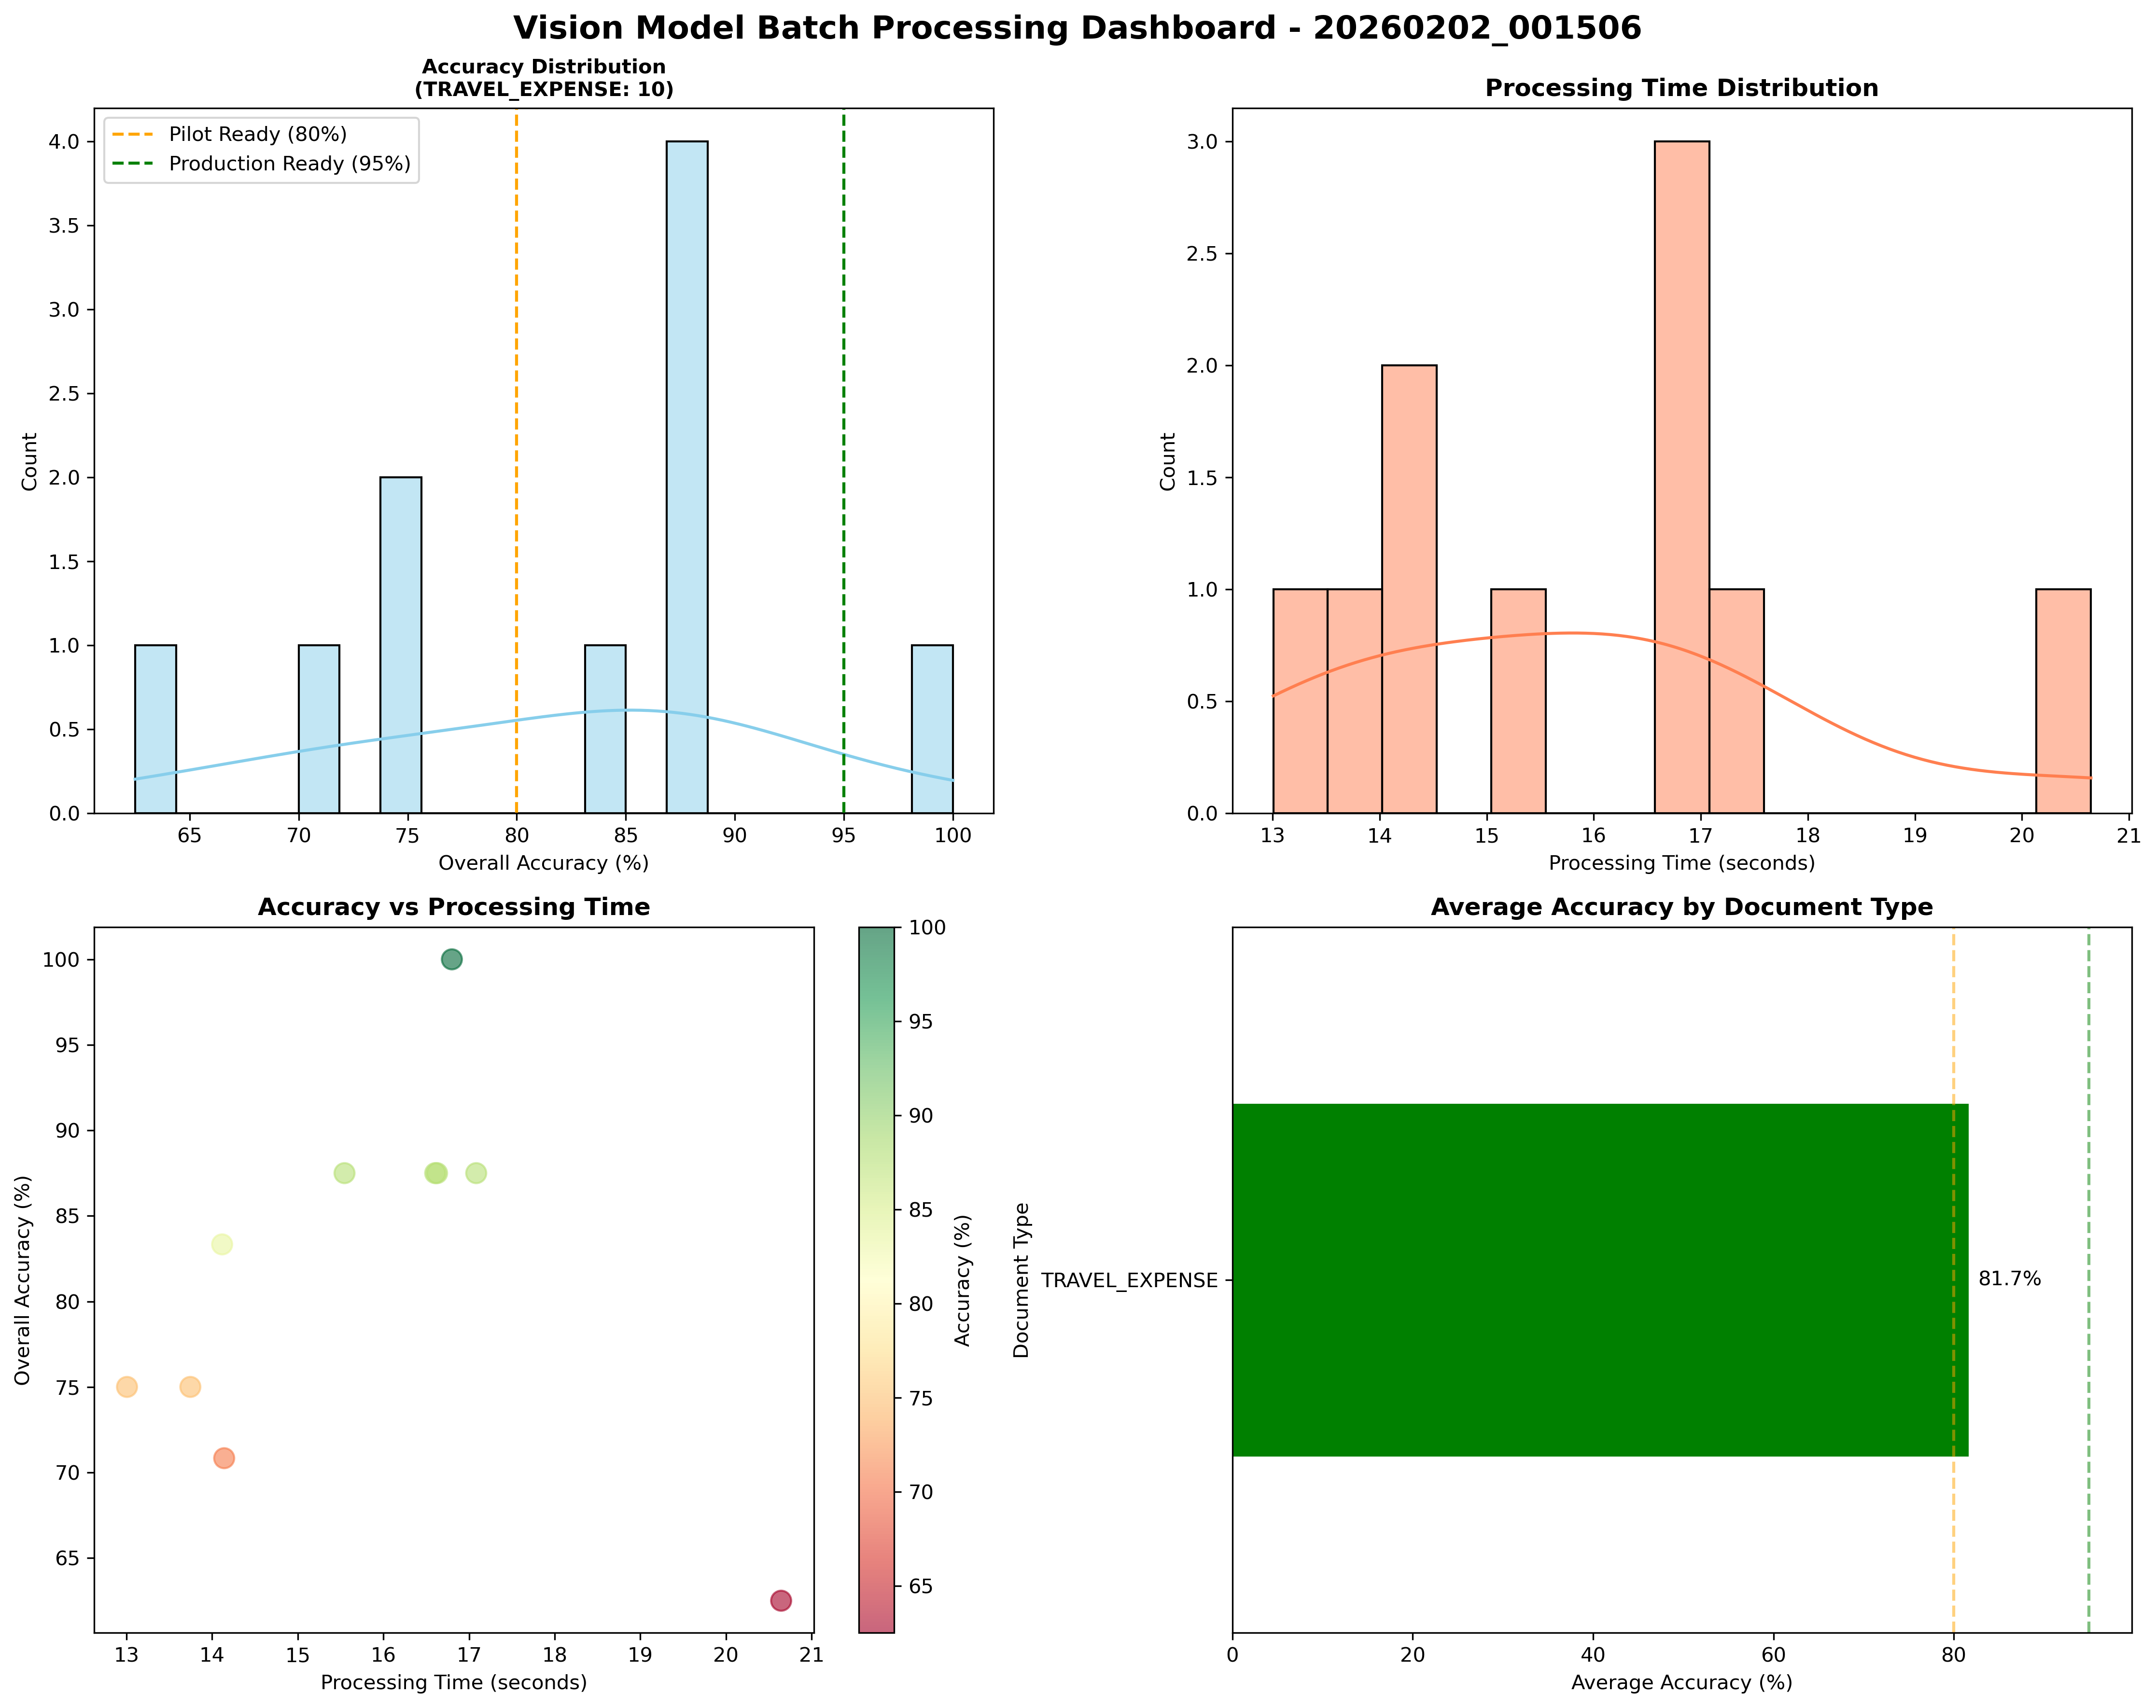

In [13]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3.5-8B Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[blue]🚀 Model: InternVL3.5-8B with Cascade RL and ViR[/blue]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:
    rprint("\n[bold green]🎉 SUCCESS: InternVL3.5-8B processing completed successfully![/bold green]")
    rprint("[green]✅ Enhanced reasoning with Cascade RL is working[/green]")
    rprint("[green]✅ Dynamic resolution adjustment with ViR is active[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 Review error logs for diagnostic information[/red]")
elif avg_accuracy < 30:
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Review extraction results for quality issues[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess performance[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [14]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )
    


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 10

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!